In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
from torch.utils.data import random_split, DataLoader
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall

%config InlineBackend.figure_format='retina'


In [20]:
device = torch.device("mps")

In [21]:
# Define transforms
transform = transforms.Compose([
    # 1) Crop out edges (CenterCrop or RandomCrop), e.g. 800x800 from 1000x2000
    transforms.RandomCrop((700, 700)),
    
    transforms.Resize((224, 224)),
    
    transforms.ToTensor(),
])

# Load entire dataset
full_dataset = datasets.ImageFolder(root='dataset_root', transform=transform)

# Define split ratios (e.g., 70% train, 15% val, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute lengths
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(42))  # fixed seed for reproducibility

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class mapping
class_names = full_dataset.classes
num_classes = len(class_names)

In [22]:
# Define model
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
model = model.to(device)

optimiser = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
criteria = nn.CrossEntropyLoss()

train_loss = MeanMetric().to(device)
epochs = 10

In [24]:
# a function for training one epoch
def train_one_epoch ():
   # Prepare for storing loss and accuracy
   losses = MeanMetric().to(device)
   acc = Accuracy(task='multiclass', num_classes=7).to(device)
   model.train()
   for X, Y in train_dataloader:
      X = X.to(device) 
      Y = Y.to(device)
      optimiser.zero_grad()
      preds = model(X)
      loss = criteria (preds, Y)
      loss.backward()
      optimiser.step() 
      preds = preds.argmax(dim=1)
      losses.update(loss, X.size(0))
      acc.update(preds, Y) 
   return losses.compute() .item(), acc.compute().item()

In [25]:
# a function for validation one epoch
def validation_one_epoch():
   losses = MeanMetric().to(device)
   acc = Accuracy(task='multiclass', num_classes=10).to(device)
   model.eval()

   for X, Y in val_dataloader:
      X = X.to(device) 
      Y = Y.to(device) 
      preds = model(X)
      loss = criteria(preds, Y)
      preds = preds.argmax(dim=1)
      losses.update(loss, X.size(0)) 
      acc.update(preds, Y)

   return losses.compute().item(), acc.compute().item()

In [26]:
for i in range(epochs):
   train_loss, train_acc = train_one_epoch() # training
   val_loss, val_acc = validation_one_epoch() # validation
   print("Epoch:", i, "| Train Loss:", round(train_loss, 3), "| Train Accuracy", round(train_acc, 3),
            "| Validation Loss", round(val_loss, 3), "| Validation Accuracy", round(val_acc, 3))

Epoch: 0 | Train Loss: 0.75 | Train Accuracy 0.721 | Validation Loss 0.741 | Validation Accuracy 0.725
Epoch: 1 | Train Loss: 0.483 | Train Accuracy 0.814 | Validation Loss 0.322 | Validation Accuracy 0.889
Epoch: 2 | Train Loss: 0.448 | Train Accuracy 0.837 | Validation Loss 0.577 | Validation Accuracy 0.791
Epoch: 3 | Train Loss: 0.32 | Train Accuracy 0.883 | Validation Loss 1.173 | Validation Accuracy 0.698
Epoch: 4 | Train Loss: 0.257 | Train Accuracy 0.907 | Validation Loss 0.728 | Validation Accuracy 0.732
Epoch: 5 | Train Loss: 0.34 | Train Accuracy 0.878 | Validation Loss 0.226 | Validation Accuracy 0.934
Epoch: 6 | Train Loss: 0.243 | Train Accuracy 0.909 | Validation Loss 0.441 | Validation Accuracy 0.818
Epoch: 7 | Train Loss: 0.244 | Train Accuracy 0.905 | Validation Loss 0.485 | Validation Accuracy 0.801
Epoch: 8 | Train Loss: 0.202 | Train Accuracy 0.926 | Validation Loss 0.392 | Validation Accuracy 0.853
Epoch: 9 | Train Loss: 0.156 | Train Accuracy 0.949 | Validation Lo

In [27]:
test_confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=num_classes)
test_acc = Accuracy(task='multiclass', num_classes=num_classes)
model = model.to('cpu') # move the model back to CPU device
model.eval() # set model to evaluation mode 
with torch.no_grad():
   for X, Y in test_dataloader:
      preds = model(X) # model forward
      preds = preds.argmax(dim=1) # obtain the final predicted class
      # store accuracy per batch
      test_confusion_matrix.update(preds, Y)
      test_acc.update(preds, Y)
   # Print the results
   print ("Confusion Matrix: \n", test_confusion_matrix.compute())
   print ("Accuracy:", test_acc.compute().item())

Confusion Matrix: 
 tensor([[95,  0,  0,  0,  0],
        [ 0, 92,  2,  0,  0],
        [ 1,  0, 64,  0,  0],
        [ 7,  0, 33, 39,  0],
        [10,  0, 14,  5, 46]])
Accuracy: 0.8235294222831726


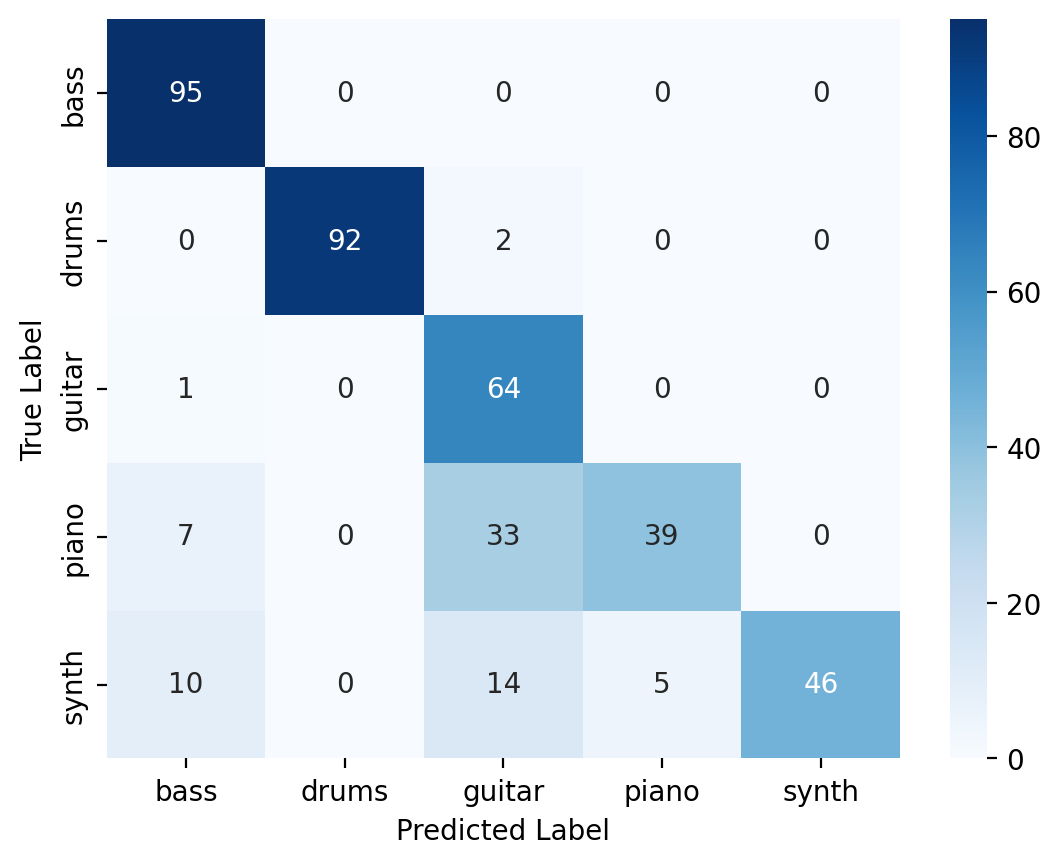

In [29]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute(), annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt. show()